<a href="https://colab.research.google.com/github/C4viar/PPD_MSLD_2019_2020_LL-AL-MT/blob/master/Draft_code/projet_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Montage du drive

In [1]:
# Montage du drive

from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


# Installation matplotlib


In [0]:
pip install matplotlib

# Contexte


Des modèles de langage du français ont tout récemment été publiés (CamemBERT, FlauBERT C’est positif car même des outils avancés comme Spacy sont notoirement encore peu adaptés à traiter certaines langues dont le français. Il reste à évaluer ce que ces modèles peuvent vraiment apporter notamment ne ce qui concerne la reconnaissances d’entités nommées.


# Travail a réaliser

Réaliser des expériences de reconnaissance d’entités nommées sur le jeu de donneés Europeana Newspapers French en utilisant tous les modèles disponibles pour cela dans la bibliothèque Simple Transformers. Les adresses à consulter sont :
* https://github.com/ThilinaRajapakse/simpletransformers
* http://api.bnf.fr/europeana-newspapers-french-ner-ground-truth

# Rendu

Un code clair et commenté dans un notebook.
Un rapport décrivant les méthodes/métriques d’évaluation (basées sur seqeval dont une description détaillée sera donnée) et présentant/comparant/discutant les résultats obtenus.


# Seqeval 

https://pypi.org/project/seqeval/

"seqeval is a Python framework for sequence labeling evaluation. seqeval can evaluate the performance of chunking tasks such as named-entity recognition, part-of-speech tagging, semantic role labeling and so on."

# Installation simple transformers, wandb

In [0]:
pip install simpletransformers

In [0]:
pip install wandb

# Installation APEX

In [4]:
! git clone https://github.com/NVIDIA/apex

fatal: destination path 'apex' already exists and is not an empty directory.


In [5]:
cd apex

/content/apex


In [0]:
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

# NER 
https://simpletransformers.ai/docs/ner-specifics/

"The goal of Named Entity Recognition is to locate and classify named entities in a sequence. The named entities are pre-defined categories chosen according to the use case such as names of people, organizations, places, codes, time notations, monetary values, etc. Essentially, NER aims to assign a class to each token (usually a single word) in a sequence. Because of this, NER is also referred to as token classification."

**Fonctionnement avec Simple Transformer**

* Initialize a NERModel
* Train the model with train_model()
* Evaluate the model with eval_model()
* Make predictions on (unlabelled) data with predict()

**Modèles disponibles à fournir à model_type** : https://huggingface.co/models

* BERT :	*bert*
* CamemBERT :	*camembert*
* RoBERTa :	*roberta*
* DistilBERT :	*distilbert*
* ELECTRA	: *electra*
* XLM-RoBERTa	: *xlmroberta*

# Test de l'ensemble des différents types de modèles

In [7]:
import pandas as pd 
import numpy as np
import os
from pandas.io.parsers import ParserError
import random
from simpletransformers.ner import NERModel
import logging
from sklearn.model_selection import train_test_split
import pickle
import plotly.express as px

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [8]:
pwd

'/content/apex'

In [9]:
cd ./..

/content


In [0]:
#cd drive/My Drive/MLDS/PPD-NER

In [11]:
cd drive/My Drive/PPD-NER

/content/drive/My Drive/PPD-NER


## Création du dataframe à partir des fichiers du jeu de données

In [0]:
# reading dataframe
# don't run other cells of this subpart to gain time

df = pd.read_csv("./out/df.csv", sep = "\t" )

In [0]:
files = os.listdir("./data") # liste des fichiers du jeu de données

In [0]:
# On lit les fichiers et on les met dans le même dataframe
# S'il y a une erreur de séparateur, alors l'exception ParserError est levée

l_bug = [] # Cette liste contiendra les dataframes ayant rencontrés l'exception ParserError
l_ok = [] # Cette liste contiendra les dataframes n'ayant pas rencontrés l'exception ParserError
df = pd.DataFrame() 

for i in files :
  try:
    # quoting = 3 pour éviter l'exception ParserError
    # certaine lignes ont pour mot : '"' ce qui pose problème car pandas les reconnait comme quote et non comme un caractère
    df = df.append(pd.read_csv("./data/"+i, sep = "\t", quoting = 3, header = None)) 
    l_ok.append(i)
  except ParserError as err :
    l_bug.append(i)

La cellule suivantes permet de connaitre la shape de l'ensemble des fichiers.
On observe que les 212 fichiers ont pour dimension : (1000, 2)

In [0]:
shape_df = pd.DataFrame(columns = ["file", "rows", "cols"])

for i in files : 
  tmp = pd.read_csv("./data/"+i, sep = "\t", quoting = 3, header = None) # lecture du fichier
  rows = tmp.shape[0] # nombre de lignes
  cols = tmp.shape[1] # nombre de colonnes
  dict_tmp = {
      "file" : i ,
      "rows" : rows,
      "cols" : cols
  }
  shape_df = shape_df.append(dict_tmp, ignore_index=True)

In [0]:
(shape_df["rows"]==1000).sum() # tous les fichiers ont la même dimension

212

La librairie simpletransformer nous impose d'avoir 3 colonnes nommées : "sentence_id", "words", "labels"

**Sentence_id** correspond au numéro de la phrase à laquelle un mot appartient. Cette information n'étant pas présente dans le jeu de données, il est nécessaire de construire cette variable nous-même.

In [0]:
df.columns = ["words", "labels"]  # on renomme les deux colonnes disponibles

In [0]:
df = df.reset_index(drop = True ) # on re-index correctement

In [0]:
# Pour définir le commencement d'une nouvelle phrase on considère que l'apparition d'un des séparateurs suivants
# "." ou "?" ou "!" signale un changement de phrase
j = 0
df["sentence_id"] = ""
for i in range(df.shape[0]):
  if (df.loc[i, "words"] in ([".", "!", "?"])):
    df.loc[i, "sentence_id"] = j
    j = j+1
  else :
    df.loc[i, "sentence_id"] = j

In [0]:
df

,words,labels,sentence_id
0,:,O,0
1,:,O,0
2,:,O,0
3,:,O,0
4,:,O,0
...,...,...,...
211995,l',O,12867
211996,orateur,O,12867
211997,dont,O,12867
211998,le,O,12867


In [0]:
df = df[["sentence_id", "words", "labels"]] # réorganisation des colonnes

In [0]:
df.to_csv("./out/df.csv", index = False, sep = "\t" ) # export du dataframe

## Analyses descriptives du dataset

In [0]:
import matplotlib.pyplot as plt

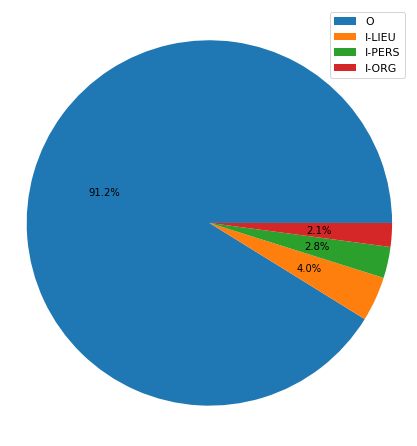

In [65]:
labels=df["labels"].value_counts().index
fig1, ax1 = plt.subplots(figsize=(8, 6))
fig1.subplots_adjust(0.3,0,1,1)
ax1.pie(df["labels"].value_counts().values, autopct='%1.1f%%')
ax1.axis('equal')
plt.legend(loc='best',
           prop={'size': 11},
           labels = labels
           )
fig1 = plt.gcf()
plt.show()
plt.show()

In [0]:
# Create rep images if necessary
# Export fig as a png file

if not os.path.exists("./images"):
    os.mkdir("./images")
fig1.savefig("./images/repartition.png")

## Test des différents type de modèles diponibles

- BERT : bert
- CamemBERT : camembert
- RoBERTa : roberta
- DistilBERT : distilbert
- ELECTRA : electra
- XLM-RoBERTa : xlmroberta

In [0]:
# Notre jeu d'entrainement sera constitué d'environ 80 pourcent des sentence_id unique (+- 10293) et 20 pourcent pour le test

randomlist = []
for i in range(0,10293):
  n = random.randint(0, df["sentence_id"].nunique())
  randomlist.append(n)


In [0]:
# Liste des étiquettes possibles à fournir au modèles

tags = df["labels"].unique().tolist()

In [0]:
# Conversion en String pour éviter des erreurs lors de la compilation

df["words"] = df["words"].astype(str)
df["labels"] = df["labels"].astype(str)

### Modèles

Les résultats des modèles seront écrit dans le dataframe results.
Il sera composé des loss, f1_score, precision et recall pour chaque modèle

In [0]:
results = pd.DataFrame(columns = ['eval_loss','f1_score','precision','recall', "type_algo", "algo"]) # création du dataframe results

l_algotype = [ "bert" , "camembert" , "roberta" , "distilbert" , "electra" , "xlmroberta"] #type de modèles
l_algo = [ "bert-base-cased" , "camembert-base" , "roberta-base" ,
          "distilbert-base-cased" , "google/electra-base-discriminator" , "xlm-roberta-base"] # modèles 

# Création de train_df et test_df
# 20 pourcent des sentences_id

train_df = df[df["sentence_id"].isin(randomlist)] # 80 pourcent des sentences_id
eval_df = df[~df["sentence_id"].isin(randomlist)] 

# configuration du logger pour les info et les avertissements
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

for i in range (len(l_algotype)) : 

  print("###################\t", l_algotype[i] , " -- ", l_algo[i] ,"\t###################")

  # Création du modèles NER
  model = NERModel(l_algotype[i], l_algo[i], args={'overwrite_output_dir': True, 'reprocess_input_data': True}, labels=tags)

  # Entrainement
  model.train_model(train_df)

  # Evaluation
  result, model_outputs, predictions = model.eval_model(eval_df)

  # Ajout du type de moèdle et du modèle tester aux résultats
  result["type_algo"] = l_algotype[i]
  result["algo"] = l_algo[i]

  # on créer une ligne contenant les résultats
  results = results.append(result, ignore_index = True)
  
#  file_model = open(r'./out/'+l_algo[i]+'.obj', 'wb')
#  # export du modèle 
#  pickle.dump(model.model, file_model)


In [0]:
results

,eval_loss,f1_score,precision,recall,type_algo,algo
0,0.203051,0.666814,0.666005,0.667624,bert,bert-base-cased
1,0.197175,0.721976,0.728431,0.715635,camembert,camembert-base
2,0.229536,0.602465,0.600088,0.604862,roberta,roberta-base
3,0.214327,0.623193,0.632045,0.614586,distilbert,distilbert-base-cased
4,0.274334,0.390286,0.440253,0.350504,electra,google/electra-base-discriminator
5,0.202448,0.698000,0.683734,0.712873,xlmroberta,xlm-roberta-base


In [0]:
# exports des résultats

# results.to_csv("./out/results.csv", sep = "," , index = False )

### Test de prédiction 

In [0]:
predictions, raw_outputs = model.predict(["Laura vit à Paris"])

In [0]:
predictions, raw_outputs = model.predict(["Amar se lève tard"])

On remarque que seuls Camembert et XMLRoberta se distinguent des autres. Nous allons donc tester une partie des différents modèles (Camembert et XMLroberta) mis à disposition : https://huggingface.co/models

In [0]:
# lecture des résultats précédemment enregistré

results = pd.read_csv("./out/results.csv", sep = ",")

In [0]:
df = pd.read_csv("./out/df.csv", sep = "\t")

# Camembert

In [0]:
# Liste des étiquettes possibles à fournir au modèles
tags = df["labels"].unique().tolist()

In [0]:
# Conversion en String pour éviter des erreurs lors de la compilation

df["words"] = df["words"].astype(str)
df["labels"] = df["labels"].astype(str)

In [0]:
camembert_results = pd.DataFrame(columns = ['eval_loss','f1_score','precision','recall', "type_algo", "algo"])

l_camembert = [ "idb-ita/gilberto-uncased-from-camembert" , "jplu/tf-camembert-base" ,
               "camembert/camembert-large" , "fmikaelian/camembert-base-fquad" , "illuin/camembert-large-fquad" ,
               "fmikaelian/camembert-base-squad"]

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Creating train_df  and eval_df for demonstration

train_df = df[df["sentence_id"].isin(randomlist)]

eval_df = df[~df["sentence_id"].isin(randomlist)]

for i in range (len(l_camembert)) : 
  try : 
    print("###################\t", "camembert" , " -- ", l_camembert[i] ,"\t###################")
    
    # Create a NERModel
    model = NERModel("camembert", l_camembert[i], args={'overwrite_output_dir': True, 'reprocess_input_data': True}, labels=tags)

    print("################### TRAIN : \t", "camembert" , " -- ", l_camembert[i] ,"\t###################")
    # Train the model
    model.train_model(train_df)

    print("################### EVAL : \t", "camembert" , " -- ", l_camembert[i] ,"\t###################")
    # Evaluate the model
    result, model_outputs, predictions = model.eval_model(eval_df)

    result["type_algo"] = "camembert"
    result["algo"] = l_camembert[i]

    camembert_results = camembert_results.append(result, ignore_index = True)

  except (AttributeError, OSError) as err : 
    pass


In [72]:
camembert_results

,eval_loss,f1_score,precision,recall,type_algo,algo
0,0.233523,0.597450,0.591697,0.603317,camembert,idb-ita/gilberto-uncased-from-camembert
1,0.188215,0.757870,0.748383,0.767601,camembert,camembert/camembert-large
2,0.213204,0.705895,0.724915,0.687848,camembert,fmikaelian/camembert-base-fquad
